In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from src.parameter_functions.tdrift import tdrift
from src.parameter_functions.rea import rea
from src.parameter_functions.dcr import find_dcr
from src.parameter_functions.peakandtailslope import extract_peak_and_tail_slope
from src.parameter_functions.current_amplitude import max_amplitude
from src.parameter_functions.fourier_lfpr import normalized_fourier, lfpr
from src.parameter_functions.lq80 import LQ80
from src.parameter_functions.agr import area_growth_rate
from src.parameter_functions.inflection import inflection_points
from src.parameter_functions.rising_edge import rising_edge_slope


In [2]:
file_path = "src/data/MJD_Test_2.hdf5"
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    data = np.array(f)

detector
energy_label
id
psd_label_dcr
psd_label_high_avse
psd_label_low_avse
psd_label_lq
raw_waveform
run_number
tp0


In [3]:
# Open the HDF5 file and extract 20 random sets
with h5py.File(file_path, 'r') as file:
    # Load the raw waveforms and labels
    raw_waveform = np.array(file["raw_waveform"])
    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    id = np.array(file["id"])

    # Create arrays to hold 20 sets of data
    random_waveforms = []
    energy_values = []
    psd_low_avse_values = []
    psd_high_avse_values = []
    psd_dcr_values = []
    psd_lq_values = []
    tp0_values = []
    detector_values = []
    run_number_values = []
    id_values = []

    # Select 20 random indices
    random_indices = np.random.choice(raw_waveform.shape[0], 20, replace=False)

    # Loop through each random index and store the corresponding data
    for idx in random_indices:
        random_waveforms.append(raw_waveform[idx])
        energy_values.append(energy_label[idx])
        psd_low_avse_values.append(psd_label_low_avse[idx])
        psd_high_avse_values.append(psd_label_high_avse[idx])
        psd_dcr_values.append(psd_label_dcr[idx])
        psd_lq_values.append(psd_label_lq[idx])
        tp0_values.append(tp0[idx])
        detector_values.append(detector[idx])
        run_number_values.append(run_number[idx])
        id_values.append(id[idx])

# Convert to numpy arrays for consistency (if needed for further processing)
random_waveforms = np.array(random_waveforms)
energy_values = np.array(energy_values)
psd_low_avse_values = np.array(psd_low_avse_values)
psd_high_avse_values = np.array(psd_high_avse_values)
psd_dcr_values = np.array(psd_dcr_values)
psd_lq_values = np.array(psd_lq_values)
tp0_values = np.array(tp0_values)
detector_values = np.array(detector_values)
run_number_values = np.array(run_number_values)
id_values = np.array(id_values)

# Output random indices and corresponding values for verification (optional)
random_indices, energy_values, psd_low_avse_values, psd_high_avse_values


(array([ 8101, 30905, 59880, 15400, 43765, 41025, 58185, 24387, 32879,
        63055, 22742, 14383, 50257, 40538, 35577, 19763, 57547, 12767,
        55053, 30617]),
 array([ 475.80678454,  294.52827437,  399.0665143 ,  290.05925563,
         240.40102996,  221.16787422,  364.22346589,  393.12814895,
         533.97485237,  172.64880319,  378.01569413,  705.94248848,
         227.68701555,  363.55764996,  340.12507201, 1143.2707533 ,
         621.46213689,  446.84730641, 1074.83222254,  582.10774155]),
 array([ True,  True, False,  True,  True, False, False, False, False,
         True, False,  True, False, False, False,  True,  True,  True,
         True, False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]))

0.16565697359010154
0.07547761064643115
0.21509319336140523
0.11539903759029602
0.038293717443359965
0.1760794254810518
0.1862579064974704
0.27130025894541654
0.20621235797276685
0.10486890066329316
0.13062315649174094
0.17055848225017192
0.06792414432180593
0.13105651942857247
0.09891685440944649
0.21334902832114006
0.12761822371614157
0.1160136234782168
0.12099217480831598
0.056764756743414725


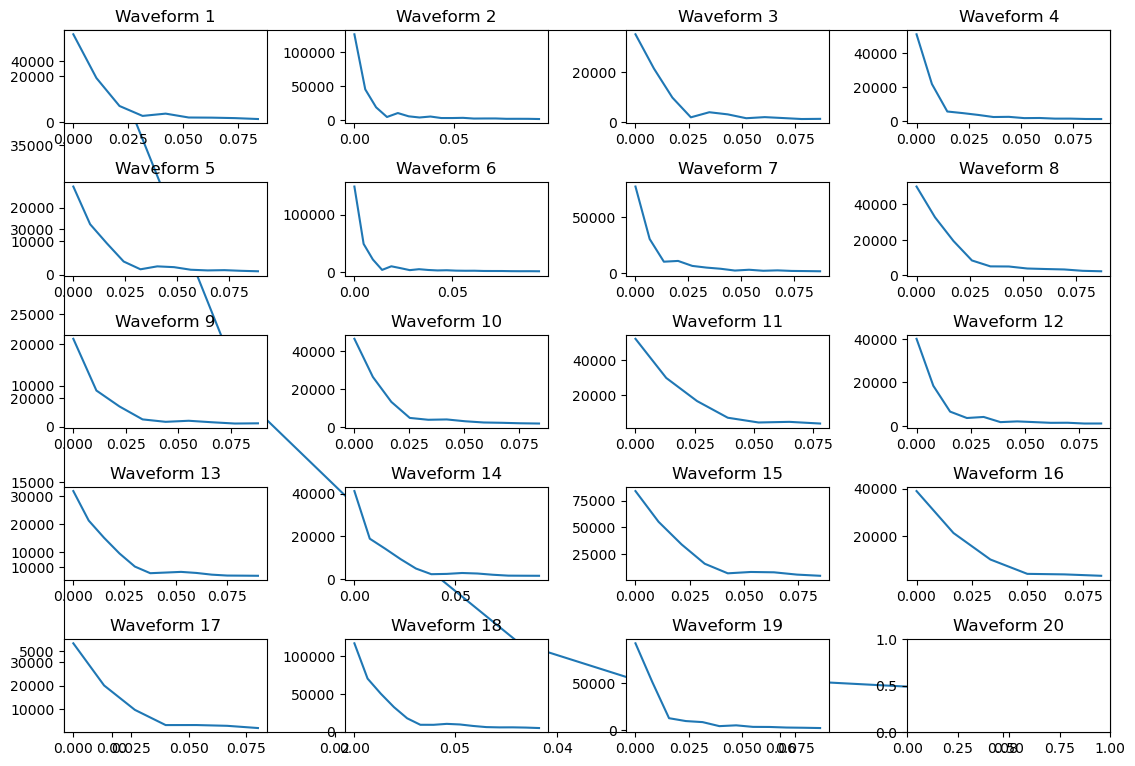

In [4]:
plt.figure(figsize=(12, 8))
for i, waveform in enumerate(random_waveforms):
    start = tp0_values[i]
    peak = np.argmax(waveform)
    tdrift = (peak-start) * 0.999
    tdrift50 = (peak-start) * 0.5
    tdrift10 = (peak-start) * 0.1
    rise80 = int((peak-start) * 0.8)
    '''plt.plot(waveform[start:peak])
    plt.plot(round(rise80), waveform[rise80+start], 'yo')
    plt.plot(int(tdrift50), waveform[int(tdrift50+start)], 'ro')
    plt.plot(int(tdrift10), waveform[int(tdrift10+start)], 'go')
    plt.subplot(5, 4, i+1)  # Create a 5x4 grid for 20 plots
    plt.title(f'Waveform {i+1}')
    plt.tight_layout()
    '''
    fft_tdrift = np.fft.fft(waveform[start:peak])
    frq_tdrift = np.fft.fftfreq(len(waveform[start:peak]), d=1)
    time_tdrift = np.arange(peak-start)
    
    # Plot the magnitude of the waveform in the frequency domain
    plt.plot(frq_tdrift[:len(frq_tdrift)//10], np.abs(fft_tdrift)[:len(frq_tdrift)//10])
    plt.subplot(5, 4, i+1)  # Create a 5x4 grid for 20 plots
    plt.title(f'Waveform {i+1}')
    plt.tight_layout()
    print(lfpr(fft_tdrift, 0.075))
plt.show()

In [5]:
for i, waveform in enumerate(random_waveforms):
    textstr = (
        f"WAVEFORM: {i+1}\n"
        f"Energy Label: {energy_values[i]}\n"
        f"PSD Label Low Avse: {psd_low_avse_values[i]}\n"
        f"PSD Label High Avse: {psd_high_avse_values[i]}\n"
        f"PSD Label DCR: {psd_dcr_values[i]}\n"
        f"PSD Label LQ: {psd_lq_values[i]}\n"
        f"Start of Rising Edge: {tp0_values[i]}\n"
        f"Detector: {detector_values[i]}\n"
        f"Run Number: {run_number_values[i]}\n"
        f"ID: {id_values[i]}"
    )
    if psd_lq_values[i] and psd_dcr_values[i] and psd_low_avse_values[i]: print(i+1)

1
2
4
5
12
16
17
18
19


In [6]:
with h5py.File(file_path, 'r') as file:
    # Load the raw waveforms
    raw_waveform = np.array(file["raw_waveform"])

    # Load other labels
    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    id = np.array(file["id"])

    # Select a random index
    random_index = np.random.choice(raw_waveform.shape[0])

    # Get the random waveform
    random_waveform = raw_waveform[random_index]

    # Access the labels for the selected index
    energy_value = energy_label[random_index]
    psd_low_avse_value = psd_label_low_avse[random_index]
    psd_high_avse_value = psd_label_high_avse[random_index]
    psd_dcr_value = psd_label_dcr[random_index]
    psd_lq_value = psd_label_lq[random_index]
    tp0_value = tp0[random_index]
    detector_value = detector[random_index]
    run_number_value = run_number[random_index]
    id_value = id[random_index]

In [7]:
start = tp0_value
peak = np.argmax(random_waveform)
tdrift = (peak-start) * 0.999
tdrift50 = (peak-start) * 0.5
tdrift10 = (peak-start) * 0.1
tdrift, tdrift50, tdrift10, tp0_value, peak

(122.877, 61.5, 12.3, 954, 1077)

Area under the curve: 150893.0
Area under the average line: 151453.29795918366
LQ80 region: 560.2979591836629
Saved as rise80.png in /src/plots/


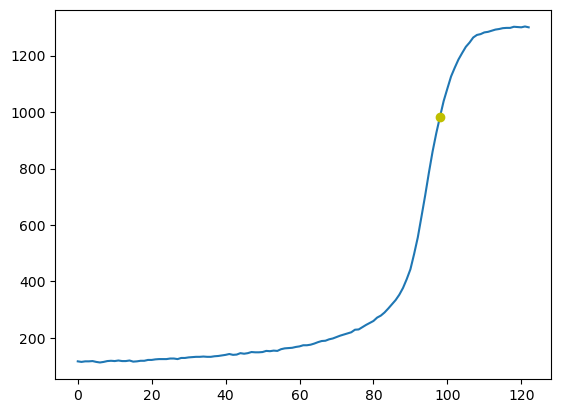

In [11]:
# Calculating the 80 percent peak
rise80 = int((peak-start) * 0.8)
plt.plot(random_waveform[start:peak])
plt.plot(rise80, random_waveform[rise80+start], 'yo')

time_window = np.arange(rise80, peak + 1)
area_under_curve = np.trapz(random_waveform[rise80:peak + 1], time_window)

average_value = np.mean(random_waveform[rise80:peak + 1])

window_width = time_window[-1] - time_window[0]
area_under_average = average_value * window_width

LQ80_region = area_under_average - area_under_curve

print(f"Area under the curve: {area_under_curve}")
print(f"Area under the average line: {area_under_average}")
print(f"LQ80 region: {LQ80_region}")

print("Saved as rise80.png in /src/plots/")
plt.savefig('src/plots/rise80.png') 

In [ ]:
# rise80 along with tdrift

plt.plot(random_waveform[start:peak])
plt.plot(round(rise80), random_waveform[rise80+start], 'yo', label='i')
plt.plot(int(tdrift50), random_waveform[int(tdrift50+start)], 'ro')
plt.plot(int(tdrift10), random_waveform[int(tdrift10+start)], 'go')

print("Saved as rise80_tdrift.png in /src/plots/")
plt.savefig('src/plots/rise80_tdrift.png') 

In [ ]:
# tdrift within the rising region

plt.figure(figsize=(10, 5))
plt.plot(random_waveform)
plt.title(f'Random Raw Waveform (Index: {random_index})')
plt.xlabel('Time Index (μs)')
plt.ylabel('ADC Counts')

textstr = (
    f"Energy Label: {energy_value}\n"
    f"PSD Label Low Avse: {psd_low_avse_value}\n"
    f"PSD Label High Avse: {psd_high_avse_value}\n"
    f"PSD Label DCR: {psd_dcr_value}\n"
    f"PSD Label LQ: {psd_lq_value}\n"
    f"Start of Rising Edge: {tp0_value}\n"
    f"Detector: {detector_value}\n"
    f"Run Number: {run_number_value}\n"
    f"ID: {id_value}"
)
plt.gcf().text(0.45, 0.2, textstr, fontsize=10)
plt.axvline(x=750, color='purple', linestyle='--', label='Region Start (750 μs)')
plt.axvline(x=1250, color='purple', linestyle='--', label='Region End (1250 μs)')
plt.axvline(x=tp0_value, color='orange', linestyle='--', label='Rising Edge (tp0)')
plt.plot(int(tdrift50+start), random_waveform[int(tdrift50+start)], 'ro', label='tdrift50 Point')
plt.plot(int(tdrift10+start), random_waveform[int(tdrift10+start)], 'go', label='tdrift10 Point')
plt.plot(int(tdrift+start), random_waveform[int(tdrift+start)], 'bo', label='tdrift Point')

plt.legend()
plt.show()

print("Saved as region_tdrift.png in /src/plots/")
plt.savefig('src/plots/region_tdrift.png') 

In [ ]:
# Difference of the waveform in time domain and frequency domain

fft_waveform = np.fft.fft(random_waveform)
frequencies = np.fft.fftfreq(len(random_waveform), d=1)  # d=1 because each index corresponds to 1 microsecond
time = np.arange(3800)
# Plot the waveform in the time domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, random_waveform)
plt.title("Random Waveform in Time Domain")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")

# Plot the magnitude of the waveform in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_waveform)[:len(frequencies)//2])  # Plotting only positive frequencies
plt.title("Waveform in Frequency Domain")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")

# Show the plots
plt.tight_layout()
plt.show()
print("Saved as diff_wave.png in /src/plots/")
plt.savefig('src/plots/diff_wave.png') 

In [ ]:
# Difference within the rising region
fft_tdrift = np.fft.fft(random_waveform[start:peak])
frq_tdrift = np.fft.fftfreq(len(random_waveform[start:peak]), d=1)
time_tdrift = np.arange(peak-start)
# Plot the waveform in the time domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_tdrift, random_waveform[start:peak])
plt.title("Random Waveform in Time Domain")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")

# Plot the magnitude of the waveform in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(frq_tdrift[:len(frq_tdrift)//2], np.abs(fft_tdrift)[:len(frq_tdrift)//2])
plt.title("Waveform in Frequency Domain")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")

# Show the plots
plt.tight_layout()
plt.show()
print("Saved as region_diff_wave.png in /src/plots/")
plt.savefig('src/plots/region_diff_wave.png') 

In [ ]:
from scipy.optimize import curve_fit

def normalized_fourier(waveform, tp0):
    peak = np.argmax(waveform)
    frq = np.fft.fftfreq(len(waveform[tp0:peak]), d=1)
    magnitude = np.abs(np.fft.fft(waveform[tp0:peak]))
    normalized_fft = magnitude / np.max(magnitude)
    return normalized_fft, frq

def sum_of_gaussians(frq, a1, mu1, sigma1, a2, mu2, sigma2):
    return (a1 * np.exp(-0.5 * ((frq - mu1) / sigma1) ** 2) +
            a2 * np.exp(-0.5 * ((frq - mu2) / sigma2) ** 2))

fft_tdrift, frq_tdrift = normalized_fourier(random_waveform, tp0_value)
peak = np.argmax(random_waveform)
time_tdrift = np.arange(peak-tp0_value)

popt, _ = curve_fit(sum_of_gaussians, frq_tdrift, fft_tdrift, p0=[1, np.mean(frq_tdrift), np.std(frq_tdrift), 0.5, np.mean(frq_tdrift) / 2, np.std(frq_tdrift) / 2])
fitted_curve = sum_of_gaussians(frq_tdrift, *popt)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_tdrift, random_waveform[tp0_value:peak])
plt.title("Random Waveform in Time Domain")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")

# Plot the magnitude of the waveform in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(frq_tdrift[:len(frq_tdrift)//4], np.abs(fft_tdrift)[:len(frq_tdrift)//4])
plt.plot(np.abs(frq_tdrift[:len(frq_tdrift)//4])**2, np.abs(fft_tdrift)[:len(frq_tdrift)//4], linestyle='--', color='red')
plt.title("Waveform in Frequency Domain")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")

# Show the plots
plt.tight_layout()
plt.show()